# Neural Nets, from Scratch, Solving a Classic Image Recognition Problem

In [39]:
import matplotlib.pyplot as plt
import numpy as np

In [1]:
from sklearn.datasets import fetch_mldata
import numpy as np
mnist = fetch_mldata('MNIST original')

In [32]:
def get_mnist_X_Y(mnist):
    data = mnist.data
    X = (data - data.min()) * 1.0 / (data.max() - data.min()) 
    target = mnist.target
    Y = np.zeros((len(target), 10))
    for i in range(len(target)):
        out[i][int(target[i])] = 1 
    return X, Y

In [33]:
X, Y = get_mnist_X_Y(mnist)

In [50]:
def visualize_image(index):
    print "Label: %s" % int(target[index])
    plt.imshow(1.0 - X[index].reshape(28,28), cmap='gray')
    plt.show()

Label: 0


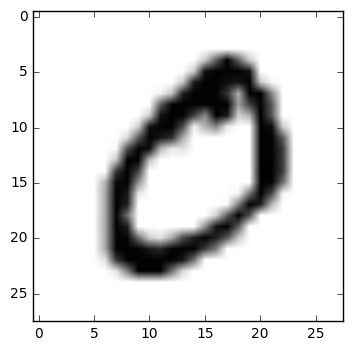

In [51]:
visualize_image(0)

In [11]:
def learn(X, y):
    np.random.seed(2)
    V = np.random.randn(784, 30)
    W = np.random.randn(30, 10)
    for j in range(150000):
        i = np.random.randint(0,70000)
        X = np.array(data_clean[i], ndmin=2)
        y = np.array(out[i], ndmin=2)
        A = np.dot(X,V)
        B = sigmoid(A)
        C = np.dot(B,W)
        P = sigmoid(C)
        sum_P = np.sum(P)
        L = 0.5 * (y - P) ** 2
        dLdP = -1.0 * (y-P)
        dPdC = sigmoid(C) * (1-sigmoid(C))
        dLdC = dLdP * dPdC
        dCdW = B.T
        dLdW = np.dot(dCdW, dLdC)
        dCdB = W.T
        dLdB = np.dot(dLdC, dCdB)
        dBdA = sigmoid(A) * (1-sigmoid(A))
        dLdA = dLdB * dBdA
        dAdV = X.T
        dLdV = np.dot(dAdV, dLdA)
        W -= dLdW
        V -= dLdV
    return V, W
        
def predict(X_new, V, W):
    A = np.dot(X_new,V)
    B = sigmoid(A)
    C = np.dot(B,W)
    P = sigmoid(C)
    return P

def sigmoid(x, bprop=False):
    if bprop:
        s = sigmoid(x)
        return s*(1-s)
    else:
        return 1.0/(1.0+np.exp(-x))

In [12]:
V, W = learn(data_clean, out)
P = predict(data_clean, V, W)

In [43]:
np.set_printoptions(suppress=True, precision=5)
P[0]

array([ 0.99998,  0.     ,  0.0002 ,  0.     ,  0.     ,  0.     ,
        0.00001,  0.00042,  0.     ,  0.     ])

In [44]:
preds = []
for el in P:
    pred = np.argmax(el)
    preds.append(pred)

In [45]:
sum(preds == target) * 1.0 / len(preds)

0.82675714285714286

# Neural Nets, from Scratch, Using Classes, Solving a Classic Image Recognition Problem

This notebook contains code to build and train a neural net, from scratch, to solve the famous [MNIST](http://yann.lecun.com/exdb/mnist/) digit recognition problem. It uses Python classes, making the code flexible and easy to build nets of arbitrary depth.

Running the cells will result in a neural net that can predict MNIST digits with 91% accuracy.

In [52]:
from sklearn.datasets import fetch_mldata
import numpy as np
mnist = fetch_mldata('MNIST original')

In [53]:
data = mnist.data

In [54]:
data_clean = (data - data.min()) * 1.0 / (data.max() - data.min()) 

In [55]:
target = mnist.target

In [56]:
out = np.zeros((len(target), 10))
for i in range(len(target)):
    out[i][int(target[i])] = 1 

In [57]:
out

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [58]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
    
    def forwardpass(self, X):
        """ Calculate an output Y for the given input X. """
        X_next = X
        for layer in self.layers:
            X_next = layer.fprop(X_next)
        prediction = X_next
        return prediction
    
    def loss(self, prediction, Y):
        """ Calculate error on the given data. """
        loss = 0.5 * (Y - prediction) ** 2
        return -1.0 * (Y - prediction)
    
    def backpropogate(self, loss):
        """ Calculate an output Y for the given input X. """
        loss_next = loss
        for layer in reversed(self.layers):
            loss_next = layer.bprop(loss_next)
        return loss
    
class Layer(object):
    def _setup(self, input_shape, rng):
        """ Setup layer with parameters that are unknown at __init__(). """
        pass

    def fprop(self, input):
        """ Calculate layer output for given input (forward propagation). """
        raise NotImplementedError()

    def bprop(self, output_grad):
        """ Calculate input gradient. """
        raise NotImplementedError()
        
def sigmoid(x, bprop=False):
    if bprop:
        s = sigmoid(x)
        return s*(1-s)
    else:
        return 1.0/(1.0+np.exp(-x))

        
class Linear(Layer):
    def __init__(self, n_in, n_out, activation_function):
        self.W = np.random.normal(loc=0.0, scale=1, size=(n_in, n_out))
        self.activation_function = activation_function
        
    def fprop(self, layer_input):
        self.layer_input = layer_input
        self.activation_input = np.dot(layer_input, self.W)
        return self.activation_function(self.activation_input, bprop=False)

    def bprop(self, layer_grad):
        dPdAi = self.activation_function(self.activation_input, bprop=True)
        dLdAi = layer_grad * dPdAi
        dAodAi = self.layer_input.T
        W_new = self.W - np.dot(dAodAi, dLdAi)
        output_grad = np.dot(dLdAi, self.W.T)
        self.W = W_new      
        return output_grad

In [59]:
nn_mnist = NeuralNetwork(
    layers=[
        Linear(n_in=784,
               n_out=30,
               activation_function=sigmoid),
        Linear(n_in=30,
               n_out=10,
               activation_function=sigmoid)
        ]
    )

In [60]:
def learn_neural_net(net, X, y):
    pred = net.forwardpass(X)
    loss = net.loss(pred, y)
    net.backpropogate(loss)
    return pred

In [61]:
for j in range(70000):
    i = np.random.randint(0,70000)
    X = np.array(data_clean[i], ndmin=2)
    y = np.array(out[i], ndmin=2)
    learn_neural_net(nn_mnist, X, y)

In [62]:
P = nn_mnist.forwardpass(data_clean)

In [63]:
P.shape

(70000, 10)

In [64]:
preds = []
for el in P:
    pred = np.argmax(el)
    preds.append(pred)

In [65]:
sum(preds == target) * 1.0 / len(preds)

0.91311428571428577

91% accuracy!